<a href="https://colab.research.google.com/github/JairVasquezT/CIFAR10-Optimization-ENSTA-Group21/blob/main/Notebook_Final_Projet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Chargement**


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Récupération des données brutes depuis les serveurs de Toronto
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

--2026-01-20 10:08:59--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  12.9MB/s    in 14s     

2026-01-20 10:09:14 (11.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# **2. Approche Initiale : Perceptron Multicouche (MLP)**

**2.1 Préparation des Données**

In [ ]:
def charger_donnees_cifar(fichier):
    """Fonction pour désérialiser les fichiers de données CIFAR-10."""
    with open(fichier, 'rb') as fo:
        # Encodage 'bytes' pour assurer la compatibilité avec les fichiers originaux
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Initialisation des listes pour regrouper les batches d'entraînement
data_list = []
labels_list = []

# Extraction des 5 batches d'entraînement (50 000 images au total)
for i in range(1, 6):
    batch = charger_donnees_cifar(f'cifar-10-batches-py/data_batch_{i}')
    data_list.append(batch[b'data'])
    labels_list.extend(batch[b'labels'])

# Fusion et conversion en formats numpy
X_all = np.concatenate(data_list)
y_all = np.array(labels_list)

# Normalisation des valeurs de pixels dans l'intervalle [0, 1]
# Cette étape est cruciale pour la stabilité numérique du gradient
X_all = X_all.astype('float32') / 255.0

# Stratégie de partitionnement des données :
# 1. Isolation de 10% du dataset pour le test final (évaluation neutre)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, y_all, test_size=0.10, random_state=42
)

# 2. Division du reste pour obtenir 20% de validation (monitoring de l'overfitting)
# Le ratio 0.222 sur le sous-ensemble garantit les proportions globales souhaitées
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.222, random_state=42
)

# Affichage des dimensions finales pour vérification de la démarche
print(f"Répartition des données :")
print(f"Images pour l'entraînement : {X_train.shape[0]}")
print(f"Images pour la validation  : {X_val.shape[0]}")
print(f"Images pour le test final  : {X_test.shape[0]}")

Répartition des données :
Images pour l'entraînement : 35010
Images pour la validation  : 9990
Images pour le test final  : 5000


**2.2 Modèle, Entraînement et Visualisation**


In [ ]:
from tensorflow.keras import optimizers, callbacks
# Architecture MLP Profonde avec Optimisations Avancées
model = models.Sequential([
    layers.Input(shape=(3072,)),

    # Couche 1 : Largeur et Normalisation pour stabiliser le gradient
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Couche 2
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Couche 3
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Couche 4 : Ajout de profondeur pour capturer plus de non-linéarité
    layers.Dense(128, activation='relu'),

    layers.Dense(10, activation='softmax')
])

# Utilisation d'un Learning Rate plus faible pour éviter les oscillations
opt = optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Ajout d'un callback pour réduire le LR si la précision stagne
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    X_train, y_train,
    epochs=60, # Augmenté car le LR est plus faible
    batch_size=64, # Un batch plus grand pour une meilleure estimation du gradient
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

Epoch 1/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.2717 - loss: 2.0910 - val_accuracy: 0.3458 - val_loss: 1.8202 - learning_rate: 5.0000e-04
Epoch 2/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3713 - loss: 1.7591 - val_accuracy: 0.3852 - val_loss: 1.7305 - learning_rate: 5.0000e-04
Epoch 3/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3937 - loss: 1.6901 - val_accuracy: 0.3657 - val_loss: 1.7718 - learning_rate: 5.0000e-04
Epoch 4/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4068 - loss: 1.6565 - val_accuracy: 0.3928 - val_loss: 1.7047 - learning_rate: 5.0000e-04
Epoch 5/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4131 - loss: 1.6406 - val_accuracy: 0.3939 - val_loss: 1.6953 - learning_rate: 5.0000e-04
Epoch 6/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4138 - loss: 1.6314 - val_accuracy: 0.4526 - val_loss: 1.5513 - learning_rate: 5.0000e-04
Epoch 7/60
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy

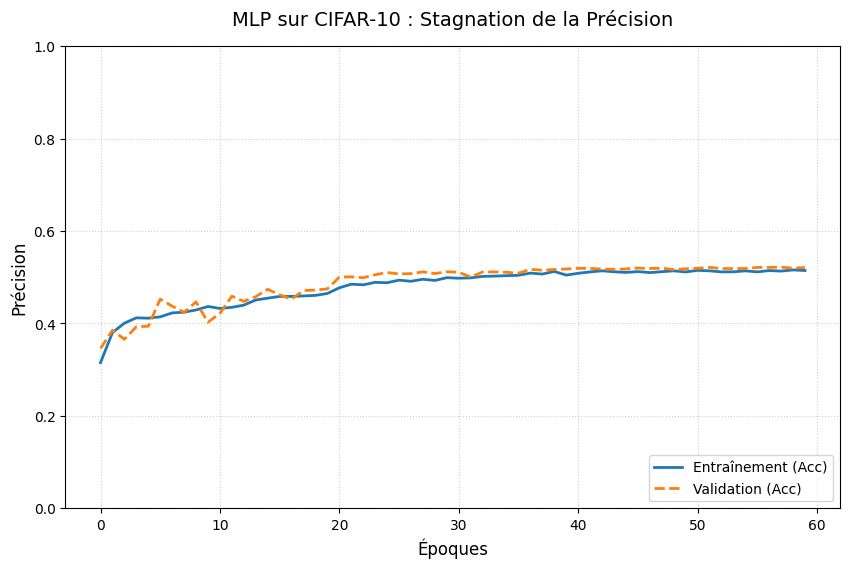

MLP - Temps moyen par image : 0.1333 ms


In [ ]:
import matplotlib.pyplot as plt
import time

def plot_mlp_results(history):
    plt.figure(figsize=(10, 6))

    # Afficher Accuracy
    plt.plot(history.history['accuracy'], label='Entraînement (Acc)', color='#1f77b4', lw=2)
    plt.plot(history.history['val_accuracy'], label='Validation (Acc)', color='#ff7f0e', lw=2, linestyle='--')

    # Formatage
    plt.title('MLP sur CIFAR-10 : Stagnation de la Précision', fontsize=14, pad=15)
    plt.xlabel('Époques', fontsize=12)
    plt.ylabel('Précision', fontsize=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.savefig('mlp_stagnation.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- AJOUTE CETTE LIGNE ICI POUR AFFICHER LE GRAPHIQUE ---
plot_mlp_results(history)

# Préparation des données (Aplatissement pour le MLP)
X_sample_flat = X_test[:1000].reshape(-1, 3072)

# Mesure de l'inférence
start_time = time.time()
_ = model.predict(X_sample_flat, verbose=0)
end_time = time.time()

# Calcul des résultats
vitesse_ms = ((end_time - start_time) / 1000) * 1000

print(f"MLP - Temps moyen par image : {vitesse_ms:.4f} ms")

# **3. Convolutional Neural Network**

 **3.1 Préparation des Tenseurs pour l'Architecture Convolutive (CNN)**

In [ ]:
# Fonction utilitaire pour extraire les fichiers binaires du dataset
def extraire_donnees(nom_fichier):
    with open(nom_fichier, 'rb') as f:
        # Encodage spécifique aux fichiers pickle du CIFAR-10
        contenu = pickle.load(f, encoding='bytes')
    return contenu

# Centralisation des données d'entraînement
donnees_entrainement = []
etiquettes_entrainement = []

for i in range(1, 6):
    lot = extraire_donnees(f'cifar-10-batches-py/data_batch_{i}')
    donnees_entrainement.append(lot[b'data'])
    etiquettes_entrainement.extend(lot[b'labels'])

# Conversion en tableaux numpy pour manipulation mathématique
X_global = np.concatenate(donnees_entrainement)
y_global = np.array(etiquettes_entrainement)

# --- ÉTAPE CRUCIALE : Remodelage pour les couches de Convolution ---
# Les données brutes sont à plat (3072). On les transforme en images 32x32x3.
# Le transpose est nécessaire car CIFAR stocke en (Canaux, Hauteur, Largeur).
X_global = X_global.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Mise à l'échelle des pixels (0 à 1) pour stabiliser le gradient
X_global = X_global.astype('float32') / 255.0

# Partitionnement des données (Train 70%, Val 20%, Test 10%)
X_provisoire, X_test, y_provisoire, y_test = train_test_split(
    X_global, y_global, test_size=0.10, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_provisoire, y_provisoire, test_size=0.222, random_state=42
)

# Vérification visuelle des dimensions pour le rapport
print(f"Structure du dataset final :")
print(f"- Images d'entraînement : {X_train.shape[0]}")
print(f"- Images de validation  : {X_val.shape[0]}")
print(f"- Images de test        : {X_test.shape[0]}")
print(f"\nDimensions du tenseur d'entrée (N, H, W, C) : {X_train.shape}")

Structure du dataset final :
- Images d'entraînement : 35010
- Images de validation  : 9990
- Images de test        : 5000

Dimensions du tenseur d'entrée (N, H, W, C) : (35010, 32, 32, 3)


**3.2 Conception du Modèle Convolutif Optimisé (CNN Custom)**

In [ ]:
# Architecture CNN personnalisée pour CIFAR-10
# Objectif : Compromis entre profondeur et vitesse d'inférence
def creer_modele_custom():
    model = models.Sequential()

    # --- Premier bloc : Extraction de caractéristiques de bas niveau ---
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.35)) # Prévention du surapprentissage précoce

    # --- Deuxième bloc : Caractéristiques intermédiaires ---
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.35))

    # --- Tête de classification ---
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.65)) # Dropout fort pour compenser la taille de la couche Dense
    model.add(layers.Dense(10, activation='softmax'))

    return model

# Initialisation et compilation
model_cnn = creer_modele_custom()

# Utilisation d'Adam avec les paramètres standards
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Affichage
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,171,178 (8.28 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

**3.3 Entraînement avec Régularisation Dynamique (Callbacks)**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration Callbacks
# 1. EarlyStopping : pour stopper si le modèle commence à surapprendre (overfitting)
surveillance_arret = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 2. ReduceLROnPlateau : pour affiner l'apprentissage quand la perte stagne
ajustement_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=5,
    min_lr=0.00025,
    verbose=1
)

# Lancement de l'entraînement du modèle CNN
# On stocke les métriques dans 'history_cnn' pour l'analyse post-entraînement
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[surveillance_arret, ajustement_lr]
)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.3370 - loss: 2.4196 - val_accuracy: 0.1536 - val_loss: 3.0782 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5301 - loss: 1.3656 - val_accuracy: 0.5761 - val_loss: 1.1735 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6114 - loss: 1.0924 - val_accuracy: 0.6200 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6585 - loss: 0.9632 - val_accuracy: 0.6728 - val_loss: 0.9178 - learning_rate: 0.0010
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6836 - loss: 0.8902 - val_accuracy: 0.7134 - val_loss: 0.8290 - learning_rate: 0.0010
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7112 - loss: 0.8242 - val_accuracy: 0.6737 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7172 - loss: 0

**3.4 Évaluation des Performances**

Résultats finaux sur données inconnues (Test) :
-> Précision (Accuracy) : 0.8244
-> Perte (Loss)         : 0.5233


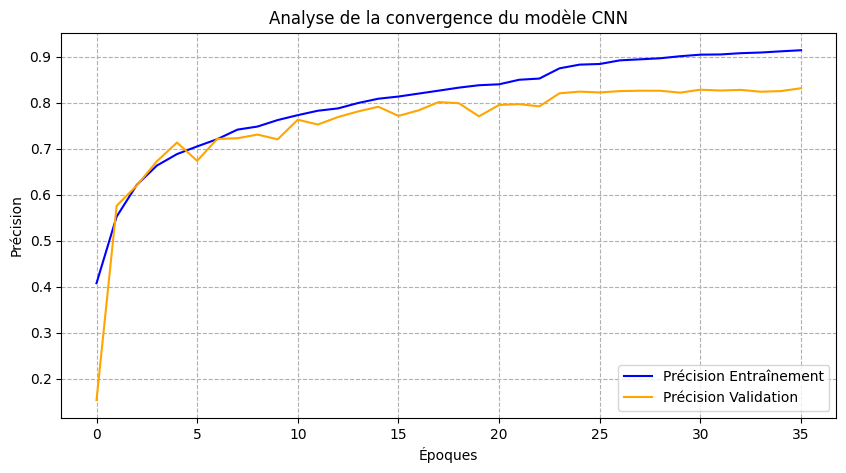


Évaluation de la rapidité (Inférence) :
Temps total pour 1000 images : 1.2110 secondes
Temps moyen par image : 1.2110 ms


In [ ]:
import time

# --- ÉVALUATION FINALE SUR LE TEST SET ---
perte_test, precision_test = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"Résultats finaux sur données inconnues (Test) :")
print(f"-> Précision (Accuracy) : {precision_test:.4f}")
print(f"-> Perte (Loss)         : {perte_test:.4f}")

# --- VISUALISATION DES COURBES D'APPRENTISSAGE ---
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='Précision Entraînement', color='blue')
plt.plot(history_cnn.history['val_accuracy'], label='Précision Validation', color='orange')
plt.title('Analyse de la convergence du modèle CNN')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.show()

# --- MESURE DE LA VITESSE D'INFÉRENCE ---
# On utilise un échantillon de 1000 images pour obtenir une moyenne stable
nombre_tests = 1000
echantillon_test = X_test[:nombre_tests]

# Début du chronométrage
top_depart = time.time()
predictions = model_cnn.predict(echantillon_test, verbose=0)
fin_mesure = time.time()

# Calcul des indicateurs de rapidité
temps_total = fin_mesure - top_depart
temps_moyen_ms = (temps_total / nombre_tests) * 1000

print(f"\nÉvaluation de la rapidité (Inférence) :")
print(f"Temps total pour {nombre_tests} images : {temps_total:.4f} secondes")
print(f"Temps moyen par image : {temps_moyen_ms:.4f} ms")

# **4. CIFAR With MobileNet**

**4.1 Préparation des Données**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
import time

# CONFIGURATION DES HYPERPARAMÈTRES (Optimisés après tests)
BATCH_SIZE = 128
L_RATE = 0.001  # Pour l'optimiseur Adam
NB_EPOCHS = 30
MACHINE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Historiques pour l'analyse des courbes d'apprentissage
historique_acc = []
historique_perte = []

print(f"Exécution sur : {MACHINE}")


In [ ]:
# 1. PRÉPARATION ET NORMALISATION

# Augmentation de données pour améliorer la robustesse du modèle
transformation_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Valeurs moyennes et écarts-types spécifiques au dataset CIFAR-10
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Pour le test, on applique uniquement la conversion en tenseur et la normalisation
transformation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# 2. CHARGEMENT DES DATASETS
# Téléchargement et préparation du jeu d'entraînement
jeu_entrainement = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transformation_train
)
train_loader = torch.utils.data.DataLoader(
    jeu_entrainement, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

# Téléchargement et préparation du jeu de test
jeu_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transformation_test
)
test_loader = torch.utils.data.DataLoader(
    jeu_test, batch_size=100, shuffle=False, num_workers=2
)

In [ ]:
# 3. CONFIGURATION DE L'OPTIMISATION

# Fonction de perte standard pour la classification multi-classe
critere_perte = nn.CrossEntropyLoss()

# Utilisation de l'optimiseur Adam pour sa convergence rapide
optimiseur = optim.Adam(model.parameters(), lr=L_RATE)

# Mise en place d'un scheduler pour affiner l'apprentissage
# On réduit le learning rate tous les 10 époques pour stabiliser la précision
planificateur = optim.lr_scheduler.StepLR(optimiseur, step_size=10, gamma=0.1)

In [ ]:

# --- 2. MODELO (MobileNetV3 Adaptada) ---
def get_cifar_mobilenet():
    # Carrega MobileNetV3 Small (versão leve)
    model = mobilenet_v3_small(weights=None)

    # ADAPTAÇÃO CRÍTICA PARA CIFAR-10 (32x32 pixels)
    # Mudamos o stride para 1 para não perder resolução cedo demais
    model.features[0][0] = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

    # Ajusta a saída para 10 classes
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, 10)
    return model

# --- 4. LOOP DE TREINAMENTO ---
def train_model():
    model.train() # Coloca em modo de treino
    print("\nIniciando Treinamento...")

    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # Zera gradientes anteriores
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calcula erro
            loss.backward() # Backpropagation
            optimizer.step() # Atualiza pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        avg_loss = running_loss / len(trainloader)
        train_acc_history.append(acc)
        train_loss_history.append(avg_loss)

        print(f"Época [{epoch+1}/{EPOCHS}] - Loss: {running_loss/len(trainloader):.3f} - Acc Treino: {acc:.2f}%")

        scheduler.step() # Atualiza learning rate

# --- 5. INFERÊNCIA E BENCHMARK (O que o exercício pede) ---
def evaluate_and_benchmark():
    model.eval() # IMPORTANTE: Modo de avaliação (desliga Dropout/Batchnorm)
    correct = 0
    total = 0

    # Medição de tempo
    start_time = time.time()

    with torch.no_grad(): # Desliga cálculo de gradientes (economiza memória e tempo)
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()

    accuracy = 100 * correct / total
    total_time = end_time - start_time
    # Calcula tempo por imagem em milissegundos
    latency_per_img = (total_time / total) * 1000

    # print(f"Época [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.3f} - Acc Treino: {acc:.2f}%")
    print("\n--- RESULTADOS FINAIS ---")
    print(f"Acurácia no Teste: {accuracy:.2f}%")
    print(f"Tempo Total para {total} imagens: {total_time:.4f} segundos")
    print(f"Latência por Imagem ({DEVICE}): {latency_per_img:.4f} ms")

    return accuracy, latency_per_img



model = get_cifar_mobilenet().to(DEVICE)

In [ ]:
train_model()
accuracy_result, lat = evaluate_and_benchmark()


Iniciando Treinamento...
Época [1/100] - Loss: 2.304 - Acc Treino: 9.82%
Época [2/100] - Loss: 2.304 - Acc Treino: 9.99%
Época [3/100] - Loss: 2.303 - Acc Treino: 10.10%
Época [4/100] - Loss: 2.304 - Acc Treino: 9.94%
Época [5/100] - Loss: 2.304 - Acc Treino: 9.89%
Época [6/100] - Loss: 2.304 - Acc Treino: 9.88%
Época [7/100] - Loss: 2.304 - Acc Treino: 9.93%
Época [8/100] - Loss: 2.304 - Acc Treino: 9.87%
Época [9/100] - Loss: 2.304 - Acc Treino: 9.91%
Época [10/100] - Loss: 2.304 - Acc Treino: 9.88%
Época [11/100] - Loss: 2.304 - Acc Treino: 9.80%
Época [12/100] - Loss: 2.304 - Acc Treino: 9.93%
Época [13/100] - Loss: 2.304 - Acc Treino: 10.01%
Época [14/100] - Loss: 2.304 - Acc Treino: 9.93%
Época [15/100] - Loss: 2.304 - Acc Treino: 10.02%
Época [16/100] - Loss: 2.304 - Acc Treino: 9.76%
Época [17/100] - Loss: 2.304 - Acc Treino: 9.84%
Época [18/100] - Loss: 2.304 - Acc Treino: 9.69%
Época [19/100] - Loss: 2.304 - Acc Treino: 9.93%
Época [20/100] - Loss: 2.304 - Acc Treino: 9.83%


KeyboardInterrupt: 

In [ ]:
print(f"\n Accuracy Model {accuracy_result}")

In [ ]:
def plot_training_history():
    epochs_range = range(1, len(train_acc_history) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_history)
    plt.xlabel("Época")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy de Treino")
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss_history)
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Loss de Treino")
    plt.grid(True)

    plt.tight_layout()
    plt.show()




In [ ]:
plot_training_history()

# **5. Destilation**

**5.1**

In [ ]:

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [ ]:

# 1. Configuração de Dispositivo (GPU é essencial aqui)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2. Prepara o CIFAR-10 (Data Augmentation é vital)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# 3. Função para modificar as ResNets para imagens 32x32
def modify_resnet_for_cifar(model):
    # Ajusta a primeira conv para não perder informação espacial
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # Remove o maxpool inicial
    model.maxpool = nn.Identity()
    # Ajusta a camada final para 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

Usando dispositivo: cpu


100%|██████████| 170M/170M [00:04<00:00, 39.3MB/s]


In [ ]:
def train_teacher(epochs=10):
    print("\n--- Iniciando Treinamento do Teacher (ResNet-50) ---")

    # Carrega ResNet50 e modifica para CIFAR
    teacher = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    teacher = modify_resnet_for_cifar(teacher).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    teacher.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = teacher(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")

    print("Treinamento do Teacher concluído.")
    # Salvamos o modelo para garantir que o Student usará este estado congelado
    torch.save(teacher.state_dict(), "teacher_cifar10.pth")
    return teacher

# Executa o treino (para teste rápido pus 5 épocas, mas o ideal é 30+)
trained_teacher = train_teacher(epochs=5)


--- Iniciando Treinamento do Teacher (ResNet-50) ---
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 71.9MB/s]


In [ ]:
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    """
    Calcula a perda combinada: KD Loss + Cross Entropy
    """
    # 1. Soft Loss (KL Divergence)
    # Teacher precisa de Softmax, Student precisa de LogSoftmax
    soft_targets = F.softmax(teacher_logits / T, dim=1)
    student_log_soft = F.log_softmax(student_logits / T, dim=1)

    # KLDivLoss espera (input=log_probs, target=probs)
    # reduction='batchmean' é matematicamente mais correto para KL
    distil_loss = nn.KLDivLoss(reduction='batchmean')(student_log_soft, soft_targets)

    # Importante: Multiplicar por T^2 para escalar os gradientes corretamente
    distil_loss = distil_loss * (T ** 2)

    # 2. Hard Loss (Cross Entropy padrão com o Label real)
    hard_loss = F.cross_entropy(student_logits, labels)

    # 3. Combinação
    loss = alpha * distil_loss + (1 - alpha) * hard_loss
    return loss

# Executa a destilação
# Nota: Passamos o 'trained_teacher' que treinamos na parte 2
student_model = train_student_kd(trained_teacher, epochs=5)

In [ ]:

def train_student_kd(teacher_model, epochs=10):
    print("\n--- Iniciando Destilação (Teacher -> Student ResNet-18) ---")

    # 1. Preparar o Student
    student = models.resnet18(weights=None) # Começa do zero
    student = modify_resnet_for_cifar(student).to(device)

    # 2. Configurações da Destilação
    T = 4.0          # Temperatura
    alpha = 0.7      # Peso da destilação (70% aprende com teacher, 30% com labels)

    optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # 3. Congelar o Teacher! (Muito importante)
    teacher_model.eval() Pros / Cons

    student.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zerar gradientes do aluno
            optimizer.zero_grad()

            # --- Forward Pass ---

            # Outputs do Teacher (Sem gradiente)
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)

            # Outputs do Student (Com gradiente)
            student_logits = student(inputs)

            # --- Cálculo da Loss ---
            loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)

            # --- Backward Pass ---
            loss.backward()
            optimizer.step()

            # Métricas
            running_loss += loss.item()
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
        print(f"Distillation Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Student Acc: {100.*correct/total:.2f}%")

    torch.save(student.state_dict(), "student_cifar10.pth")
    return student

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ---------------------------------------------------------
# 1. SETUP E DADOS (Mantido do exemplo anterior)
# ---------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformações para CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Função para modificar ResNet para CIFAR-10 (32x32px)
def modify_resnet_for_cifar(model):
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# ---------------------------------------------------------
# 2. DEFINIÇÃO DA FUNÇÃO DE DESTILAÇÃO (Seu Código Aqui)
# ---------------------------------------------------------
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    """
    Função extraída do tutorial do PyTorch e integrada aqui.
    """
    ce_loss = nn.CrossEntropyLoss()
    # O tutorial usa Adam. ResNets geralmente preferem SGD, mas mantive Adam
    # para ser fiel ao seu snippet.
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher em modo de avaliação
    student.train() # Student em modo de treino

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass com o Teacher (sem gradientes)
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass com o Student
            student_logits = student(inputs)

            # --- A Lógica do Tutorial ---
            # Suaviza os logits aplicando softmax/log_softmax com temperatura T
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calcula a perda de soft targets manualmente
            # Fórmula: sum(P * (log P - log Q)) -> que é a KL Divergence
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calcula a perda real (Hard labels)
            label_loss = ce_loss(student_logits, labels)

            # Soma ponderada
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss Média: {running_loss / len(train_loader):.4f}")

# Função auxiliar de teste
def test(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

# ---------------------------------------------------------
# 3. EXECUÇÃO
# ---------------------------------------------------------

# A) Carregar o Teacher (Assumindo que você já tem ou treinou o ResNet-50)
print("Preparando Teacher...")
teacher = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
teacher = modify_resnet_for_cifar(teacher).to(device)

# ATENÇÃO: Em um cenário real, você carregaria os pesos treinados aqui:
# teacher.load_state_dict(torch.load("teacher_cifar10.pth"))
# Como é um exemplo, vamos supor que ele já está treinado.

# B) Criar o Student (ResNet-18) do zero
print("Criando Student...")
student = models.resnet18(weights=None)
student = modify_resnet_for_cifar(student).to(device)

# C) Rodar a Destilação usando SUA função
print("Iniciando Destilação com a função do Tutorial PyTorch...")

# Hiperparâmetros do tutorial:
# T=2, alpha=0.25 (soft) / 0.75 (hard), lr=0.001 (padrão do Adam)
train_knowledge_distillation(
    teacher=teacher,
    student=student,
    train_loader=train_loader,
    epochs=5,  # Reduzi para testar rápido, aumente para 10-30
    learning_rate=0.001,
    T=2.0,
    soft_target_loss_weight=0.25,
    ce_loss_weight=0.75,
    device=device
)

# D) Avaliar Resultado Final
acc = test(student, test_loader, device)
print(f"Acurácia Final do Student: {acc:.2f}%")